# Gradient Descent



Today we will discuss:
1. What is the purpose of gradient descent for neural networks
2. What is a gradient
3. what is gradient descent

To answer this question, let us take the task of building and training a network for multiplication by 3.

In [111]:
import numpy as np

X = np.array([[1], [3], [2], [10], [4], [7], [8]])
y = np.array([[3, 9, 6, 30, 12, 21, 24]]).T

In [112]:
from keras.layers import Dense
from keras.models import Sequential
import tensorflow as tf
tf.random.set_seed(0)


model = Sequential([
    Dense(1, input_shape=(1,), activation='linear')
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 1)                   │               2 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

Весов у нас выходит две штуки, это вышло из-за того, что для каждого нейрона в линейном слое есть отклонение (bias).

In [113]:
w1, w0 = model.get_weights()
w1 = w1[0][0]
w0 = w0[0]

w1, w0

(-0.8986099, 0.0)

Now let's make a prediction with this model on one


In [114]:
X[:1]

array([[1]])

In [115]:
model.predict(X[:1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


array([[-0.8986099]], dtype=float32)

In [116]:
w1 * X[:1] + w0

array([[-0.89860988]])

In [117]:
from keras.activations import linear
linear(w1 * X[:1] + w0)

array([[-0.89860988]])

Optimize/reduce MSE error - and this is a function that varies with the weights in the neuron.

We can take 100 different values of weights and calculate MSE in them and display it on a three-dimensional graph.

We will also display the weights that we have at the moment of network initialization

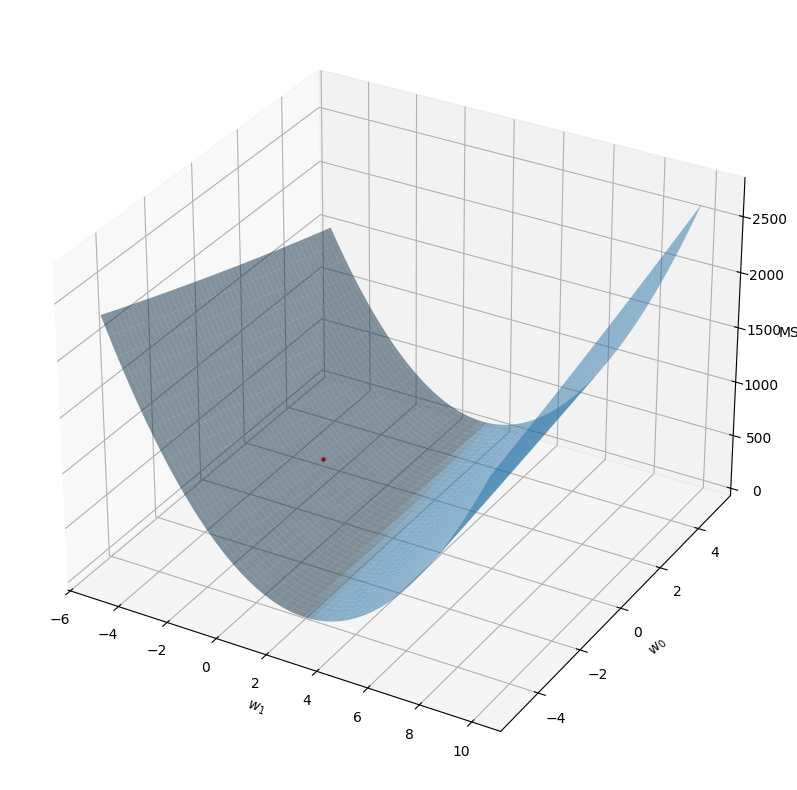

In [118]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
import matplotlib.pyplot as plt


def mse(w1, w0):
    y_pred = w1 * X[:, 0] + w0
    return np.mean((y - y_pred) ** 2)


coefs_w1 = np.linspace(-5, 10, num=100)
coefs_w0 = np.linspace(-5, 5, num=100)
w1s, w0s = np.meshgrid(coefs_w1, coefs_w0)


fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

zs = np.array([mse(i, j) for i, j in zip(np.ravel(w1s), np.ravel(w0s))])
Z = zs.reshape(w1s.shape)

ax.plot_surface(w1s, w0s, Z, alpha=.5)
ax.scatter(w1, w0, mse(w1, w0), c='r', s=5)

ax.set_xlabel(r'$w_1$')
ax.set_ylabel(r'$w_0$')
ax.set_zlabel('MSE')

plt.show()

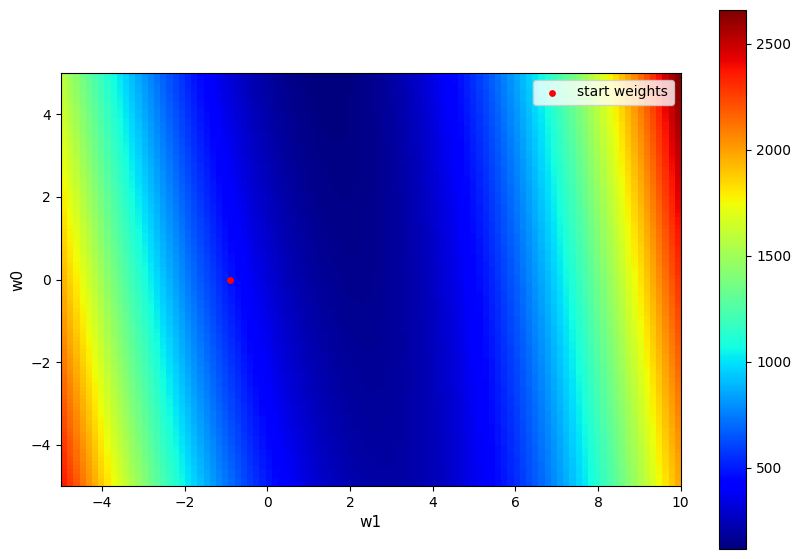

In [119]:
coefs_w1 = np.linspace(-5, 10, num=100)
coefs_w0 = np.linspace(-5, 5, num=100)
w1s, w0s = np.meshgrid(coefs_w1, coefs_w0)

zs = np.array([round(mse(i, j)) for i, j in zip(np.ravel(w1s), np.ravel(w0s))])
Z = zs.reshape(w1s.shape)

fig = plt.figure(figsize = (10,7))
plt.imshow(Z, extent=[-5,10, -5,5], origin = 'lower', cmap = 'jet', alpha = 1)
plt.colorbar()
plt.scatter(w1, w0, c='r', s=15, label='start weights')


plt.xlabel('w1', fontsize=11)
plt.ylabel('w0', fontsize=11)

plt.legend(loc="upper right");

To be in the lowest error we need to reach it, and we can go to it using gradient descent.


> **Gradient descent** is a method of finding the local minimum or maximum of a function by moving along a gradient.

The _Gradient_ of a function $f$ is a $n$-dimensional vector of partial derivatives.

$$ \nabla f(x_{1},...,x_{d}) = \left(\frac{\partial f}{\partial x_{i}}\right)^{d}_{i=1}.$$

For example, if a function depends on three variables: $F(x, y, z)$, then its gradient will be equal to

$$\nabla f(x, y, z) = (\frac{\partial f}{\partial x}, \frac{\partial f}{\partial y}, \frac{\partial f}{\partial z}) $$

In this case, the __gradient sets the direction of the fastest growth of the function__. So, the antigradient will show the direction of its fastest decrease, which will be useful for us in our problem of minimizing the error functional.

Let's try to implement programmatically gradient descent on our example to better understand how it works.

The *function* we optimize here is MSE, its graph for our particular problem was drawn above.


1. mserror - mean square error function $MSE = \frac{1}{n}\sum_{i=0}^n{(\text{y}_i-\text{y_pred}_i})^2 = \frac{1}{n}\sum_{i=0}^n{(\text{y}_i-(w_1\cdot X_i + w_0)})^2 = \frac{1}{n}\sum_{i=0}^n{(\text{y}_i-w_1\cdot X_i - w_0})^2$


2. gr_mserror is the gradient of the MSE function. Let's describe it separately for scales:


$w_1$:
$\frac{∂ MSE}{∂ w_1} = \frac{1 \cdot 2}{n}\sum({y_i -\text{y_pred}_i})\cdot -X$

$w_0$:
$\frac{∂ MSE}{∂ w_0} = \frac{1 \cdot 2}{n}\sum({y_i -\text{y_pred}_i})\cdot -1$


In [120]:

def mserror(X, w1, w0, y):
    y_pred = w1 * X[:, 0] + w0
    return np.sum((y - y_pred) ** 2) / len(y_pred)


def gr_mserror(X, w1, w0, y):
    y_pred = w1 * X + w0
    return {'grad_w1': 2/len(y)*np.sum((y - y_pred) * (-X)),
            'grad_w0': 2/len(y)*np.sum((y - y_pred)) * (-1)}

Перед тем, как считать градиенты и перед тем, как запускать градиентный спуск, давайте посчитаем ошибку

In [121]:
preds = X * w1 + w0
preds

array([[-0.89860988],
       [-2.69582963],
       [-1.79721975],
       [-8.98609877],
       [-3.59443951],
       [-6.29026914],
       [-7.18887901]])

In [122]:
import pandas as pd

df = pd.DataFrame({
   'true': np.squeeze(y),
   'pred': np.squeeze(preds)
})

df

,true,pred
0,3,-0.898610
1,9,-2.695830
2,6,-1.797220
3,30,-8.986099
4,12,-3.594440
5,21,-6.290269
6,24,-7.188879


In [123]:
np.mean((df['true'] - df['pred']) ** 2)

527.6279471076064

Инициализация начальной точки

In [124]:
weights_1 = [w1]
weights_0 = [w0]

In [125]:
grad = gr_mserror(X, w1, w0, y)
grad

{'grad_w1': -270.67491429192677, 'grad_w0': -38.986098766326904}

In [126]:
next_w_1 = w1 - grad['grad_w1']
next_w_0 = w0 - grad['grad_w0']

next_w_1, next_w_0

(269.7763044152941, 38.986098766326904)

In [127]:
preds = X * next_w_1 + next_w_0

df = pd.DataFrame({
   'true': np.squeeze(y),
   'pred': np.squeeze(preds)
})

df

,true,pred
0,3,308.762403
1,9,848.315012
2,6,578.538708
3,30,2736.749143
4,12,1118.091316
5,21,1927.420230
6,24,2197.196534


In [128]:
np.mean((df['true'] - df['pred']) ** 2)

2576127.299876956

The error is quite gigantic, so something went wrong. Namely, the gradients went wrong, they are very large, i.e. the function grows faster than it decreases in the other direction.

To avoid this we can use the learning rate.

> **Learning rate** is a parameter of gradient algorithms that allows you to control the amount of weight correction at each iteration.

In [129]:
grad = gr_mserror(X, w1, w0, y)
grad

{'grad_w1': -270.67491429192677, 'grad_w0': -38.986098766326904}

In [130]:
lr = 0.01

In [131]:
next_w_1 = w1 - lr * grad['grad_w1']
next_w_0 = w0 - lr * grad['grad_w0']

weights_1.append(next_w_1)
weights_0.append(next_w_0)

next_w_1, next_w_0

(1.8081392662865774, 0.38986098766326904)

The resulting weights are not as large as after the first run.

Let's calculate the error

In [132]:
preds = X * next_w_1 + next_w_0

df = pd.DataFrame({
   'true': np.squeeze(y),
   'pred': np.squeeze(preds)
})

df

,true,pred
0,3,2.198000
1,9,5.814279
2,6,4.006140
3,30,18.471254
4,12,7.622418
5,21,13.046836
6,24,14.854975


In [133]:
np.mean((df['true'] - df['pred']) ** 2)

44.81814557339012

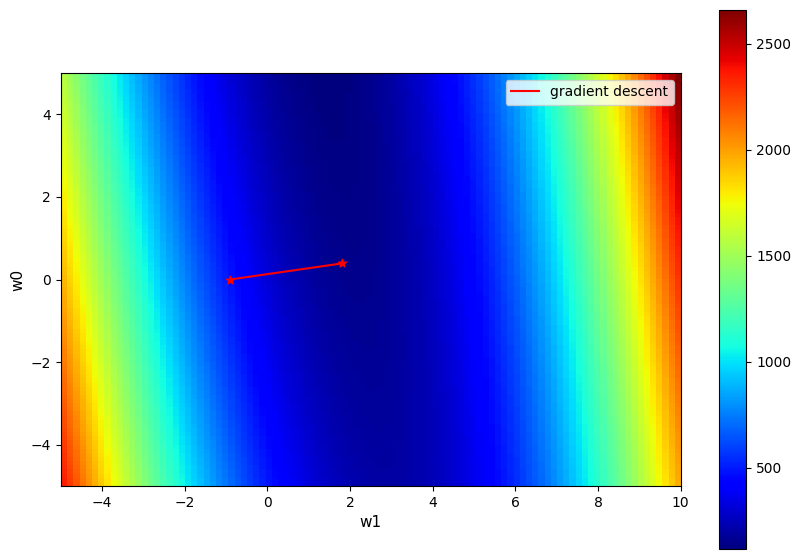

In [134]:
coefs_w1 = np.linspace(-5, 10, num=100)
coefs_w0 = np.linspace(-5, 5, num=100)
w1s, w0s = np.meshgrid(coefs_w1, coefs_w0)

zs = np.array([round(mse(i, j)) for i, j in zip(np.ravel(w1s), np.ravel(w0s))])
Z = zs.reshape(w1s.shape)

fig = plt.figure(figsize = (10,7))
plt.imshow(Z, extent=[-5,10, -5,5], origin = 'lower', cmap = 'jet', alpha = 1)
plt.colorbar()


plt.plot(weights_1, weights_0, label='gradient descent', c='r')
plt.scatter(weights_1, weights_0, marker='*', c='r')

plt.xlabel('w1', fontsize=11)
plt.ylabel('w0', fontsize=11)

plt.legend(loc="upper right");

In [135]:
grad = gr_mserror(X, next_w_1, next_w_0, y)
grad

{'grad_w1': -78.85057820689921, 'grad_w0': -11.138885361807686}

In [136]:
next_w_1 = next_w_1 - lr * grad['grad_w1']
next_w_0 = next_w_0 - lr * grad['grad_w0']

weights_1.append(next_w_1)
weights_0.append(next_w_0)

next_w_1, next_w_0

(2.5966450483555694, 0.5012498412813459)

In [137]:
preds = X * next_w_1 + next_w_0

df = pd.DataFrame({
   'true': np.squeeze(y),
   'pred': np.squeeze(preds)
})

np.mean((df['true'] - df['pred']) ** 2)

3.877283596310368

Движемся в правильном направлении, судя по ошибке.

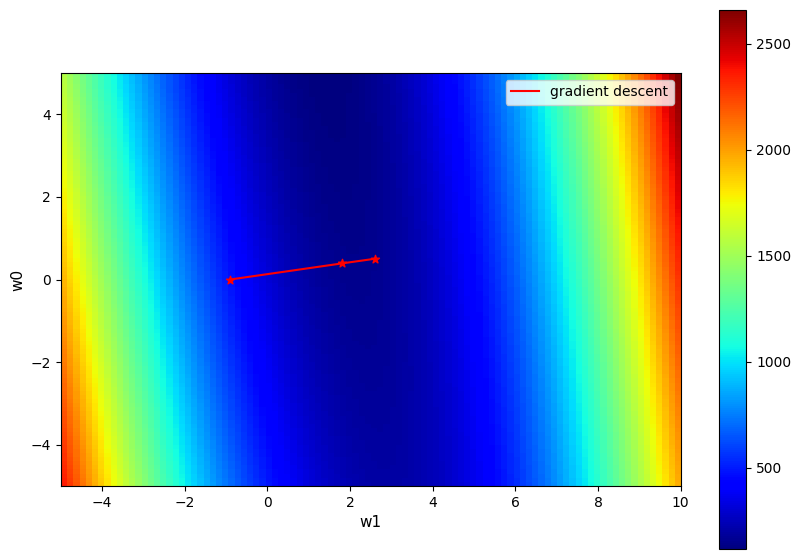

In [138]:
coefs_w1 = np.linspace(-5, 10, num=100)
coefs_w0 = np.linspace(-5, 5, num=100)
w1s, w0s = np.meshgrid(coefs_w1, coefs_w0)

zs = np.array([round(mse(i, j)) for i, j in zip(np.ravel(w1s), np.ravel(w0s))])
Z = zs.reshape(w1s.shape)

fig = plt.figure(figsize = (10,7))
plt.imshow(Z, extent=[-5,10, -5,5], origin = 'lower', cmap = 'jet', alpha = 1)
plt.colorbar()


plt.plot(weights_1, weights_0, label='gradient descent', c='r')
plt.scatter(weights_1, weights_0, marker='*', c='r')

plt.xlabel('w1', fontsize=11)
plt.ylabel('w0', fontsize=11)

plt.legend(loc="upper right");

In [139]:
# количество итерация
n = 100

for i in range(n):
    cur_weight_1 = next_w_1
    cur_weight_0 = next_w_0
    grad = gr_mserror(X, cur_weight_1, cur_weight_0, y)

    next_w_1 = cur_weight_1 - lr * grad['grad_w1']
    next_w_0 = cur_weight_0 - lr * grad['grad_w0']

    weights_1.append(next_w_1)
    weights_0.append(next_w_0)

In [140]:
preds = X * cur_weight_1 + cur_weight_0

df = pd.DataFrame({
   'true': np.squeeze(y),
   'pred': np.squeeze(preds)
})

df

,true,pred
0,3,3.271960
1,9,9.179583
2,6,6.225771
3,30,29.856263
4,12,12.133394
5,21,20.994829
6,24,23.948640


In [141]:
np.mean((df['true'] - df['pred']) ** 2)

0.028329143024312223

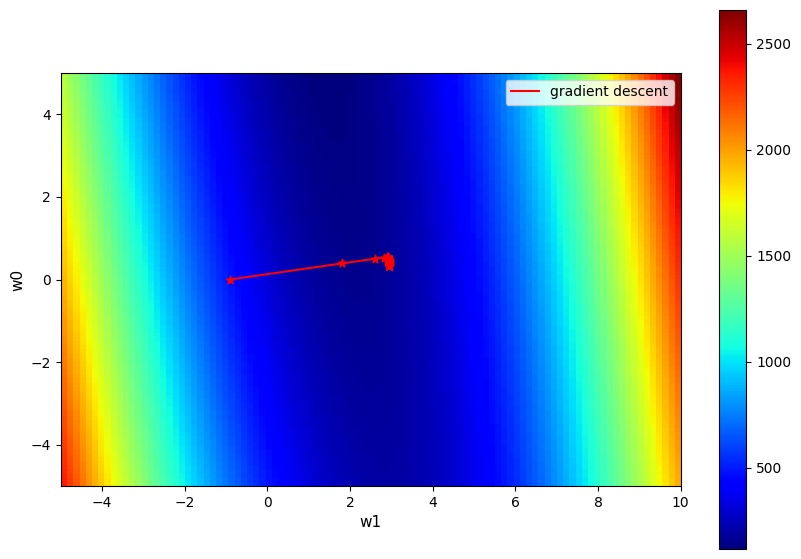

In [142]:
coefs_w1 = np.linspace(-5, 10, num=100)
coefs_w0 = np.linspace(-5, 5, num=100)
w1s, w0s = np.meshgrid(coefs_w1, coefs_w0)

zs = np.array([round(mse(i, j)) for i, j in zip(np.ravel(w1s), np.ravel(w0s))])
Z = zs.reshape(w1s.shape)

fig = plt.figure(figsize = (10,7))
plt.imshow(Z, extent=[-5,10, -5,5], origin = 'lower', cmap = 'jet', alpha = 1)
plt.colorbar()


plt.plot(weights_1, weights_0, label='gradient descent', c='r')
plt.scatter(weights_1, weights_0, marker='*', c='r')

plt.xlabel('w1', fontsize=11)
plt.ylabel('w0', fontsize=11)

plt.legend(loc="upper right");

#### Gradient Descent Algorithm

1. initialization of the starting point
2. Cycle by k = 1,2,3,...:

- $ w_{k} = w_{k-1} - \eta\nabla f(w_{k-1}) $


In [143]:
df = pd.DataFrame({
   'true': np.squeeze(y),
   'pred': np.squeeze(model.predict(X))
})

np.mean((df['true'] - df['pred']) ** 2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


527.6279505600388

In [144]:
model.compile(optimizer='sgd', loss='mse', metrics=['mae'])

In [145]:
model.get_weights()[0][0][0], model.get_weights()[1][0]

(-0.8986099, 0.0)

In [146]:
n_epochs = 10
weights = [[model.get_weights()[0][0][0], model.get_weights()[1][0]]]

for i in range(n_epochs):
    model.fit(X, y)
    weights.append([model.get_weights()[0][0][0], model.get_weights()[1][0]])

weights = np.array(weights)
weights

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - loss: 527.6279 - mae: 19.4930
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 44.8181 - mae: 5.5694
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3.8773 - mae: 1.5435
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.4048 - mae: 0.4939
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1096 - mae: 0.3044
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0837 - mae: 0.2618
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0807 - mae: 0.2484
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0796 - mae: 0.2436
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0788 - mae: 0.2412
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0779 - mae: 0.2396


array([[-0.8986099 ,  0.        ],
       [ 1.8081393 ,  0.38986102],
       [ 2.596645  ,  0.50124985],
       [ 2.8265636 ,  0.53156036],
       [ 2.893822  ,  0.5382728 ],
       [ 2.9137125 ,  0.53812516],
       [ 2.9198081 ,  0.5359914 ],
       [ 2.921885  ,  0.53329074],
       [ 2.92279   ,  0.5304364 ],
       [ 2.9233522 ,  0.5275487 ],
       [ 2.9238129 ,  0.5246625 ]], dtype=float32)

In [147]:
import pandas as pd

df = pd.DataFrame({
   'true': np.squeeze(y),
   'pred': np.squeeze(model.predict(X))
})

df

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


,true,pred
0,3,3.448475
1,9,9.296101
2,6,6.372288
3,30,29.762791
4,12,12.219913
5,21,20.991352
6,24,23.915165


In [148]:
np.mean((df['true'] - df['pred']) ** 2)

0.07704374605866958

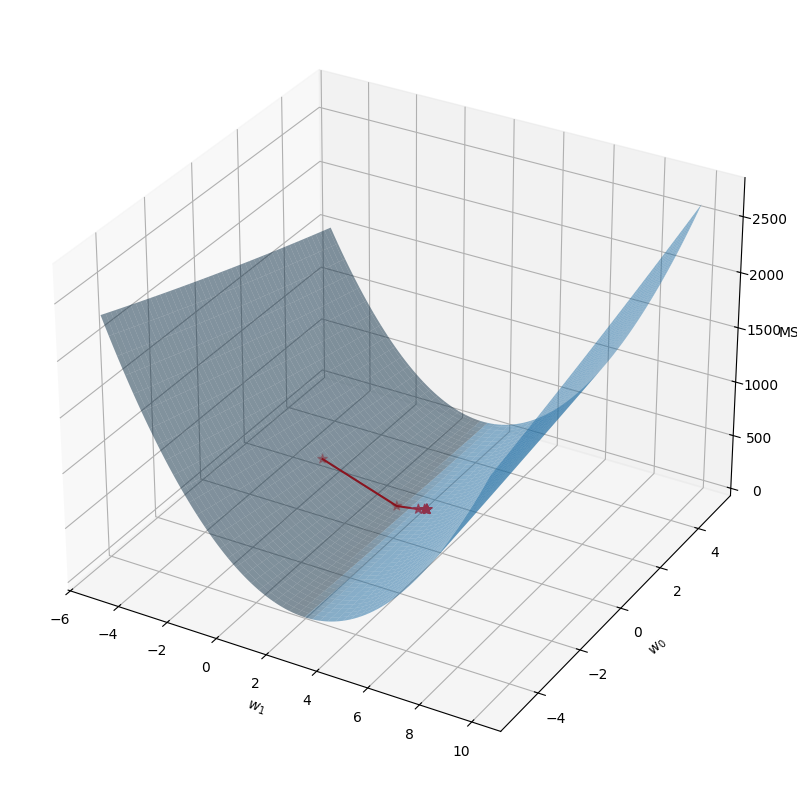

In [149]:
coefs_w1 = np.linspace(-5, 10, num=100)
coefs_w0 = np.linspace(-5, 5, num=100)
w1s, w0s = np.meshgrid(coefs_w1, coefs_w0)


fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

zs = np.array([mse(i, j) for i, j in zip(np.ravel(w1s), np.ravel(w0s))])
Z = zs.reshape(w1s.shape)

ax.plot_surface(w1s, w0s, Z, alpha=.5)

mses = []
for weight1, weight0 in weights:
    mses.append(mse(weight1, weight0))

ax.plot(weights[:, 0], weights[:, 1], mses, label='gradient descent', c='r')
ax.scatter(weights[:, 0], weights[:, 1], mses, c='r', marker='*', s=50)


ax.set_xlabel(r'$w_1$')
ax.set_ylabel(r'$w_0$')
ax.set_zlabel('MSE')

plt.show()

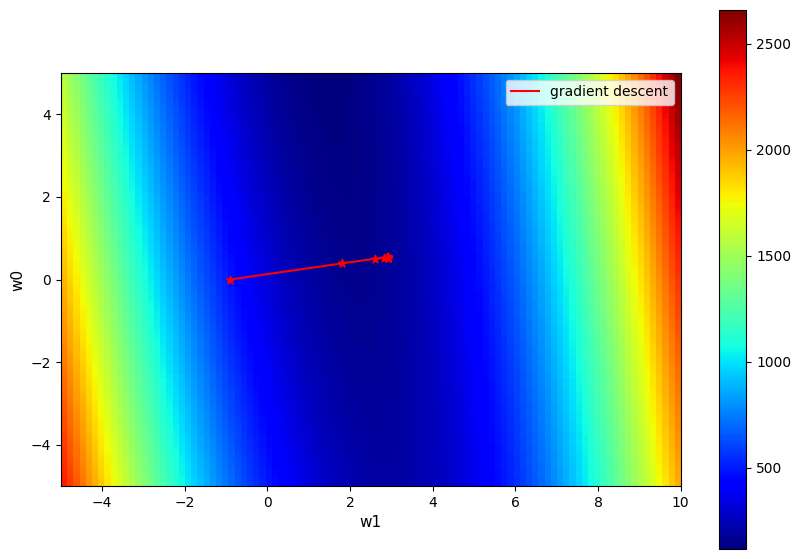

In [150]:
coefs_w1 = np.linspace(-5, 10, num=100)
coefs_w0 = np.linspace(-5, 5, num=100)
w1s, w0s = np.meshgrid(coefs_w1, coefs_w0)

zs = np.array([round(mse(i, j)) for i, j in zip(np.ravel(w1s), np.ravel(w0s))])
Z = zs.reshape(w1s.shape)

fig = plt.figure(figsize = (10,7))
plt.imshow(Z, extent=[-5,10, -5,5], origin = 'lower', cmap = 'jet', alpha = 1)
plt.colorbar()


plt.plot(weights[:, 0], weights[:, 1], label='gradient descent', c='r')
plt.scatter(weights[:, 0], weights[:, 1], marker='*', c='r')

plt.xlabel('w1', fontsize=11)
plt.ylabel('w0', fontsize=11)

plt.legend(loc="upper right");